# Notebook for plotting figures for compress++ experiments

# 0. Import libraries, and fix plot setting

In [115]:
from argparse import ArgumentParser
import copy
import joblib

import numpy as np
import numpy.random as npr
import numpy.linalg as npl
from scipy.spatial.distance import pdist

import pathlib
import os
import os.path
import pickle as pkl

# Fitting linear models
import statsmodels.api as sm
from scipy.stats import multivariate_normal

# plottibg libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
import pylab
import seaborn as sns
plt.style.use('seaborn-white')

# utils for generating samples, evaluating kernels, and mmds
from util_sample import sample, compute_mcmc_params_p, compute_diag_mog_params, sample_string, compute_params_p
from util_k_mmd import get_combined_mmd_filename, compute_params_k
from util_filenames import get_file_template, get_combined_file_template
from util_parse import init_parser

from construct_compresspp_coresets import construct_compresspp_coresets
from construct_kt_coresets import construct_kt_coresets
from construct_st_coresets import construct_st_coresets
from construct_herding_coresets import construct_herding_coresets

# Autoreload packages that are modified
%load_ext autoreload
%autoreload 2
# %matplotlib inline
%load_ext line_profiler
# https://jakevdp.github.io/PythonDataScienceHandbook/01.07-timing-and-profiling.html

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [116]:
ylab_size = 25
xlab_size = 25
leg_size = 25
title_size = 30
ylab = 'Mean MMD' 

In [117]:
fix_plot_settings = True
if fix_plot_settings:
    plt.rc('font', family='serif')
    plt.rc('text', usetex=False)
    label_size = 20
    mpl.rcParams['xtick.labelsize'] = label_size 
    mpl.rcParams['ytick.labelsize'] = label_size 
    mpl.rcParams['axes.labelsize'] = label_size
    mpl.rcParams['axes.titlesize'] = label_size
    mpl.rcParams['figure.titlesize'] = label_size
    mpl.rcParams['lines.markersize'] = label_size
    mpl.rcParams['grid.linewidth'] = 2.5
    mpl.rcParams['legend.fontsize'] = label_size
    pylab.rcParams['xtick.major.pad']=5
    pylab.rcParams['ytick.major.pad']=5

#     lss = ['-', '-.',  ':', '--',  '--', '-.', ':', '-', '--', '-.', ':', '-']*2
#     mss = ['>', 'o',  's', 'D', '>', 's', 'o', 'D', '>', 's', 'o', 'D']*2
#     ms_size = [25, 20, 20, 20, 20, 20, 20, 20, 20, 20]
#     colors = ['#e41a1c',  'magenta','#4daf4a', '#0000cd',  'cyan', 'black' ,'orange','yellow','gray']*2
    ## adjust colors a bit
    lss = ['-', '-.',  ':', '--',  '--', '-.', ':', '-', '--', '-.', ':', '-']*2
    mss = ['>', 's', 'o', 'D', '+', '*',  '>', 's', 'o', 'D', '>', 's', 'o', 'D']*2
    ms_size = [25, 20, 20, 20, 20, 20, 20, 20, 20, 20]
    colors = ['#e41a1c', 'cyan',   '#0000cd',   '#4daf4a', 'magenta', 'black' ,'orange','yellow','gray']*2
    colors = ['#e41a1c', #red
              'orange',  
              '#0000cd', #blue
                '#4daf4a', #green
              'magenta', 'black' , 'yellow','gray']*2
else:
    pass

In [118]:
def plot_mmd_dict_new(axes, ms, mmds_dict, size_factor=1., fit_model=True, error_bar = True, error_shade = False, 
                  skip_ns=int(0), legend_size=mpl.rcParams['legend.fontsize'], rm_keys = [], summary=np.mean, 
                  legend_loc = 'best',
                 change_cpthin=False,
                 alpha_kt = 1.,
                 adjust_g = False,
                 sizes_kt = None,
                 sizes_non_kt = None,
                     basex=2,
                     basey=2):
    '''
        Plot mmd error rates
        axes: axes objet for a matplotlib figure
        ms: array of integers denoting the logarithmic range of coreset size (m=log_2 coreset size)
        mmds_dict: Dictionary of mmd rates; each entry should have size Rep x len(ms)
        size_factor: Float, scaling of marker size
        fit_model: Whether fit a log-log least squares model
        error_bar: Boolean, When true error bars across Reps are plotted for each key in mmds_dict
        error_shade: Boolean, When true shaded error regions are be plotted for each key in mmds_dict
        skip_ns: Integer, starting index for the plot (how many entries to skip in ms, and mmds_dict keys)
        legend_size: float, Size of the legend in the plot
        rm_keys: list, keys not to be plotted
        summary: function, to be used for combining results across reps
        legend_loc: str, location of legend
        change_cpthin: Boolean, whether to only plot ST, KT, KT-Comp, KT-Comp++
        alpha_kt: Float, The alpha size for the kt markers/lines
        adjust_g: Boolean, whether to plot only plot g = 0 and 4 (True)
        sizes_kt: list of integers, contains input sizes (in log_4) for 
                  which kt results are to be plotted
        sizes_non_kt: list of integers, contains input sizes (in log_4) 
                      for which non-kt results are to be plotted
        basex: float, log base for x-axis (as we always plot on log-scale)
        basey: float, log base for y-axis (as we always plot on log-scale)
        
    '''
    ns = np.power(4, ms[skip_ns:], dtype=int)
    X = sm.add_constant(np.log(ns))
    ls = []
    labs = []
    mmds_dict_new = mmds_dict.copy()
    for rm_key in rm_keys:
        mmds_dict_new.pop(rm_key, None)
    
    if change_cpthin:
        for label in ["CPthin+KT-1", "CPthin+KT-2", "CPthin+KT-3", "CP+KT-1", "CP+KT-2", "CP+KT-3", "CP+KTnosymm-0"]:
            if label in mmds_dict_new.keys():
                mmds_dict_new.pop(label, None)

    for i, (label, mmd) in enumerate(mmds_dict_new.items()):
        if adjust_g:
            if label == "KT" or label== "Herd":
                assert(sizes_kt is not None)
                ms = range(sizes_kt[0], sizes_kt[1]+1)
            else:
                assert(sizes_non_kt is not None)
                ms = range(sizes_non_kt[0], sizes_non_kt[1]+1)
        ns = np.power(4, ms[skip_ns:], dtype=int)
        X = sm.add_constant(np.log(ns))
        
        alpha = 1.
        if label == "KT":
            alpha = alpha_kt
        if change_cpthin:
            if label == "CPthin+KT-0" or label=="CP+KT-0":
                label = "KT-Comp"
            if label == "CPthin+KT-4" or label=="CP+KT-4":
                label = "KT-Comp++"
                
            if label == "CPHerd-4":
                label = "Herd-Comp++"
            if label == "CPHerd-0":
                label = "Herd-Comp"
                
            if label == "CP+KTnosymm-4":
                label = "KT-Comp++(NS)"
            
                
            
        if summary == np.mean or summary == np.nanmedian:
            y = summary(mmd, axis=1)
            yerr = np.nanstd(mmd, axis=1) / np.sqrt((~np.isnan(mmd)).sum(axis=1))
            y = y[skip_ns:]
            yerr = yerr[skip_ns:]
        else:
            y = mmd
            yerr = np.zeros_like(y)
            
        if fit_model:
            # print(mmds_dict_new)
            model = sm.OLS(np.log(y), X).fit()
        
        if not(error_bar) and not(error_shade):
            l1, = axes.plot(ns, y, marker=mss[i], linestyle='None', 
                           color=colors[i], alpha=alpha, markersize=size_factor*ms_size[i])
        
        else:
            if error_bar:
                l1 = axes.errorbar(ns, y, marker=mss[i], yerr=np.array([np.zeros_like(yerr), yerr]), linestyle='None', 
                            color=colors[i], alpha=alpha, markersize=size_factor*ms_size[i], linewidth=5)
            if error_shade:
                axes.fill_between(ns, y-yerr, y+yerr, alpha=0.2, color=colors[i])
          
        if fit_model:
            l2, = axes.plot(ns, np.exp(model.predict(X)),
                                   linestyle=lss[i],
                                   linewidth=4, color=colors[i], alpha=.5)
        
        if fit_model:
            labs.append(label.replace("_", " ") + r": n$^{%.2f}$"%(model.params[1]))
            ls.append((l1, l2))
        else:
            labs.append(label.replace("_", " "))
            ls.append((l1))

        axes.legend(ls, labs, loc=legend_loc, handletextpad=0.0, fontsize=legend_size)
        axes.set_xscale('log', base=basex)
        axes.set_yscale('log', base=basey)
        axes.spines['top'].set_visible(False)
        # ax.spines['left'].set_visible(False)
        axes.spines['right'].set_visible(False)
        # ax.spines['bottom'].set_visible(False)
        axes.grid(True, alpha=0.4)
    return

### additional functions to parse arguments, combine results, and format the results

In [119]:
def parse_arguments():
    '''
    Function for initializing arguments
    '''
    parser = init_parser()
    parser.add_argument('--size_min', '-size_min', type=int, default=0,
                            help="min size")
    parser.add_argument('--size_max', '-size_max', type=int, default=3,
                            help="max size")
    parser.add_argument('--cset', '-cset', type=str, default='KT',
                       help="which type of coreset results to combine")
    args, opt = parser.parse_known_args()
    return(args)

In [120]:
def combine_results(args, params_p, params_k_split, params_k_swap, adjust_g=False):
    '''
    Return a dictionary of mmd results
    args: dictionary containing arguments for the experiments; usually 
          containing the keys returned by the dictionary in parse_arguments 
    params_p: dictionary containing keys describing the target distribution 
    params_k_split: dictionary containing keys describing the split kernel
    params_k_swap: dictionary containing keys describing the swap kernel 
                   (when herding is passed, we generally pass params_k_split = params_k_swap)
    adjust_g: Boolean flag if we want to plot compress++ results only for g = 0, 4
    
    '''
    temp_args = copy.deepcopy(args)
    
    folder = "results/combined"
    pathlib.Path(folder).mkdir(parents=True, exist_ok=True)
    
    prefix = args.cset 
    file_template = get_combined_file_template(folder, prefix, args.d, args.size_min,
                    args.size_max, args.size_max, params_p, params_k_split, params_k_swap, 
                    delta=0.5, experiment_seed=args.seed, compressalg = args.compressalg)
    
    combo_filename  = file_template.format("combined_mmd", f"s{args.rep0}-{args.rep0+args.repn}")
    # print(combo_filename)
    if not args.recombine and os.path.exists(combo_filename):
        mmd_results = joblib.load(combo_filename)
    else:
        mmd_results = dict()
        if args.cset == "ST":
            mmd_results[args.cset] = dict() # np.zeros((args.size_max-args.size_min+1, args.repn-args.rep0))
            for i, sz in enumerate(range(args.size_min, args.size_max+1)):
                mmd_results[args.cset]["size_%d"%sz] = np.zeros(args.repn)
                temp_args.size = sz
                temp_args.m = sz
                mmd_results[args.cset] ["size_%d"%sz] = construct_st_coresets(temp_args)
                
        # by default there is no difference between CP+KT and CPthin+KT
        if args.cset == "CP+KT":
            mmd_results[args.cset] = dict()
            
            for i, sz in enumerate(range(args.size_min, args.size_max+1)):
                if adjust_g:
                    gs = [0, 4]
                mmd_results[args.cset]["size_%d"%sz] = dict()
                for g in gs if 'gs' in locals() else range(min(args.g_max, sz)+1):
                    mmd_results[args.cset]["size_%d"%sz]["g_%d"%g] = np.zeros(args.repn)
                    temp_args.size = sz
                    temp_args.g = g
                    temp_args.m = sz
                    temp_args.compressalg ="kt"
                    mmd_results[args.cset]["size_%d"%sz]["g_%d"%g] = construct_compresspp_coresets(temp_args)    

        if args.cset == "KT":
            mmd_results[args.cset] = dict() # np.zeros((args.size_max-args.size_min+1, args.repn-args.rep0))
            for i, sz in enumerate(range(args.size_min, args.size_max+1)):
                mmd_results[args.cset]["size_%d"%sz] = np.zeros(args.repn)
                temp_args.size = sz
                temp_args.m = sz
                mmd_results[args.cset]["size_%d"%sz] = construct_kt_coresets(temp_args)
        if args.cset == "Herd":
            mmd_results[args.cset] = dict() # np.zeros((args.size_max-args.size_min+1, args.repn-args.rep0))
            for i, sz in enumerate(range(args.size_min, args.size_max+1)):
                mmd_results[args.cset]["size_%d"%sz] = np.zeros(args.repn)
                temp_args.size = sz
                temp_args.m = sz
                mmd_results[args.cset]["size_%d"%sz] = construct_herding_coresets(temp_args)
        if args.cset == "CPHerd":
            mmd_results[args.cset] = dict()
            if adjust_g:
                gs = [0, 4]
            for i, sz in enumerate(range(args.size_min, args.size_max+1)):
                mmd_results[args.cset]["size_%d"%sz] = dict()
#                 gs = [0, 4]
#                 gs = [0, 1, 2, 3, 4]
                for g in gs if 'gs' in locals() else range(min(args.g_max, sz)+1):
                    mmd_results[args.cset]["size_%d"%sz]["g_%d"%g] = np.zeros(args.repn)
                    temp_args.size = sz
                    temp_args.g = g
                    temp_args.m = sz
                    temp_args.compressalg ="herding"
                    mmd_results[args.cset]["size_%d"%sz]["g_%d"%g] = construct_compresspp_coresets(temp_args)    
                
        joblib.dump(mmd_results, combo_filename)
    return( mmd_results)


In [121]:
def post_process(mmd_results, args, keys=["KT"], adjust_g=False, sizes_non_kt=None, sizes_kt = [4, 8]):
    '''
    Format mmd_results dictionary returned by combine_results into a simpler format 
    that can then be passed to plot_mmd_dict_new for plotting results
    '''
    mmd_dict = dict()
    if sizes_non_kt is None:
        sizes_non_kt = [args.size_min, args.size_max]
    if not adjust_g:
        sizes_kt = sizes_non_kt
    else:
        assert(sizes_kt is not None)

    for key in keys:
        if key == "ST":
            num_sizes = 1+sizes_non_kt[1]-sizes_non_kt[0]
            assert(len(mmd_results[key][key].keys())==num_sizes)
            mmd_dict[key] = np.zeros((num_sizes, args.repn))
            for i, (_, values) in enumerate(mmd_results[key][key].items()):
                mmd_dict[key][i, :] = values
        if key == "KT":
            num_sizes = 1+sizes_kt[1]-sizes_kt[0]
            assert(len(mmd_results[key][key].keys())==num_sizes)
            mmd_dict[key] = np.zeros((num_sizes, args.repn))
            for i, (_, values) in enumerate(mmd_results[key][key].items()):
                mmd_dict[key][i, :] = values
        if key == "Herd":
            num_sizes = 1+sizes_kt[1]-sizes_kt[0]
            mmd_dict[key] = np.zeros((num_sizes, args.repn))
            for i, (_, values) in enumerate(mmd_results[key][key].items()):
                mmd_dict[key][i, :] = values
        if key == "CPHerd":
            if adjust_g:
                gs = [0, 4]
            else:
                gs = range(min(args.g_max + 1, args.size_max+1))
            num_sizes = 1+sizes_non_kt[1]-sizes_non_kt[0]
            for i in gs:
                mmd_dict[key+f"-{i}"] = np.zeros((num_sizes, args.repn))
                for j, sz in enumerate(range(sizes_non_kt[0], sizes_non_kt[1]+1)):
                    mmd_dict[key+f"-{i}"][j, :] = mmd_results[key][key][f'size_{sz}'][f'g_{i}']
        if "CP+KT" in key: # for Hinch
            if adjust_g:
                gs = [0, 4]
            else:
                gs = range(min(args.g_max + 1, args.size_max+1))
            num_sizes = 1+sizes_non_kt[1]-sizes_non_kt[0]
            assert(len(mmd_results[key][key].keys())==num_sizes)
            for i in gs:
                mmd_dict[key+f"-{i}"] = np.zeros((num_sizes, args.repn))
                for j, sz in enumerate(range(sizes_non_kt[0], sizes_non_kt[1]+1)):
                    # print(mmd_results[key][key])
                    mmd_dict[key+f"-{i}"][j, :] = mmd_results[key][key][f'size_{sz}'][f'g_{i}']
    return(mmd_dict)
            

In [122]:
fig_dir = 'figs/'

# set parameters here

In [133]:
## gauss experiments
run_gauss_experiments = True
ds = [2, 4, 10, 100]

## mog experiments
run_mog_experiments = False
Ms = [4, 6, 8]

run_mcmc_experiments = False # run experiments with MCMC P
all_mcmc_filenames = ['Goodwin_RW', 'Goodwin_ADA-RW', 
'Goodwin_MALA', 'Goodwin_PRECOND-MALA', 
'Lotka_RW', 'Lotka_ADA-RW', 
'Lotka_MALA', 'Lotka_PRECOND-MALA',  
     'Hinch_P_seed_1_temp_1_scaled_nosplit',
     'Hinch_P_seed_2_temp_1_scaled_nosplit',
     'Hinch_TP_seed_1_temp_8_scaled_nosplit', 
     'Hinch_TP_seed_2_temp_8_scaled_nosplit']


combined_mmd_results = dict()

# 1. Gauss Results

## 1.1 Load and plot KT results

In [134]:
### flags ####

st_coresets = True # whether to load standard thin coresets
kt_coresets = True # whether to load kt coresets
cpp_kt_coresets = True # whether to load compress++ with kt coresets
herding_coresets = False # whether to load herding coresets
cpp_herding_coresets = False # whether to load compress++ with herding coresets


### g and size parameters ###

adjust_g = True # only compress (g=0) and compress++ with g=4 will be loaded
sizes_kt = [4, 8] # range of sizes for kt and herding results
sizes_non_kt = [4, 9] # range of sizes for compress++ results

if adjust_g is False: 
    sizes_kt = None
    sizes_non_kt = None

In [135]:
## load results ##

args = parse_arguments()

args.krt = 0 # 0 if no krt, anything else for krt

# mmd and size params
args.combine_mmd = 1  # whether to combine mmd
args.computemmd = 1 # whether to compute mmd; if set to 0, the code might behave weirdly
args.size_min, args.size_max = 4, 7 # min and max size parameters for the input (in log_4 base)
args.rep0 = 0 # starting rep count/idx
args.repn = 10 # number of repeats
args.g_max = 4 # max value of g
args.symm1 = 1 # whether symmetrize was used in first stage

# rerun/compute params
args.rerun = 0 
args.recomputemmd = 0 # CHECK THIS

# recombine
args.recombine = False # whether to create a new combined mmd file in case one already exists

if run_gauss_experiments:
    args.setting = "gauss"
    for d in ds:
        args.d = d
        combined_mmd_results["d_%d"%d] = dict()
        
        # compute d, params_p and var_k for the setting
        d, params_p, var_k = compute_params_p(args)

        # define the kernels
        params_k_split, params_k_swap, _, _ = compute_params_k(d=d, var_k=var_k, 
                                                            use_krt_split=args.krt, name="gauss")
        flags = [st_coresets, cpp_kt_coresets, kt_coresets,  cpp_herding_coresets, herding_coresets]
        labels = ["ST", "CP+KT", "KT", "CPHerd", "Herd"]
        for f, lab in zip(flags, labels):
            if f:
                if adjust_g:
                    if lab == "KT" or lab == "Herd":
                        args.size_min, args.size_max = sizes_kt[0], sizes_kt[1]
                    else:
                        args.size_min, args.size_max = sizes_non_kt[0], sizes_non_kt[1]
                    
                args.cset = lab
                combined_mmd_results["d_%d"%d][lab] = dict()
                combined_mmd_results["d_%d"%d][lab] = combine_results(args, params_p, params_k_split, params_k_swap, adjust_g=adjust_g)

Running ST experiment with template coresets_folder/ST-mmd-gauss_var1.0_seed3285393467-splitgauss_var4.000-swapgauss_var4.000-d2-sz4-m4-delta0.5-rep0.pkl.....
Loading mmd from coresets_folder/ST-mmd-gauss_var1.0_seed3285393467-splitgauss_var4.000-swapgauss_var4.000-d2-sz4-m4-delta0.5-rep0.pkl (already present)
-elapsed time: 0.00346 (s)
Running ST experiment with template coresets_folder/ST-mmd-gauss_var1.0_seed97002651-splitgauss_var4.000-swapgauss_var4.000-d2-sz4-m4-delta0.5-rep1.pkl.....
Loading mmd from coresets_folder/ST-mmd-gauss_var1.0_seed97002651-splitgauss_var4.000-swapgauss_var4.000-d2-sz4-m4-delta0.5-rep1.pkl (already present)
-elapsed time: 0.00265 (s)
Running ST experiment with template coresets_folder/ST-mmd-gauss_var1.0_seed1575725543-splitgauss_var4.000-swapgauss_var4.000-d2-sz4-m4-delta0.5-rep2.pkl.....
Loading mmd from coresets_folder/ST-mmd-gauss_var1.0_seed1575725543-splitgauss_var4.000-swapgauss_var4.000-d2-sz4-m4-delta0.5-rep2.pkl (already present)
-elapsed time:

In [136]:
## set plotting keys ##
plot_keys = []
for f, lab in zip(flags, labels):
    if f:
        plot_keys.append(lab)
print(plot_keys)

basex = 4
basey = 2

['ST', 'CP+KT', 'KT']


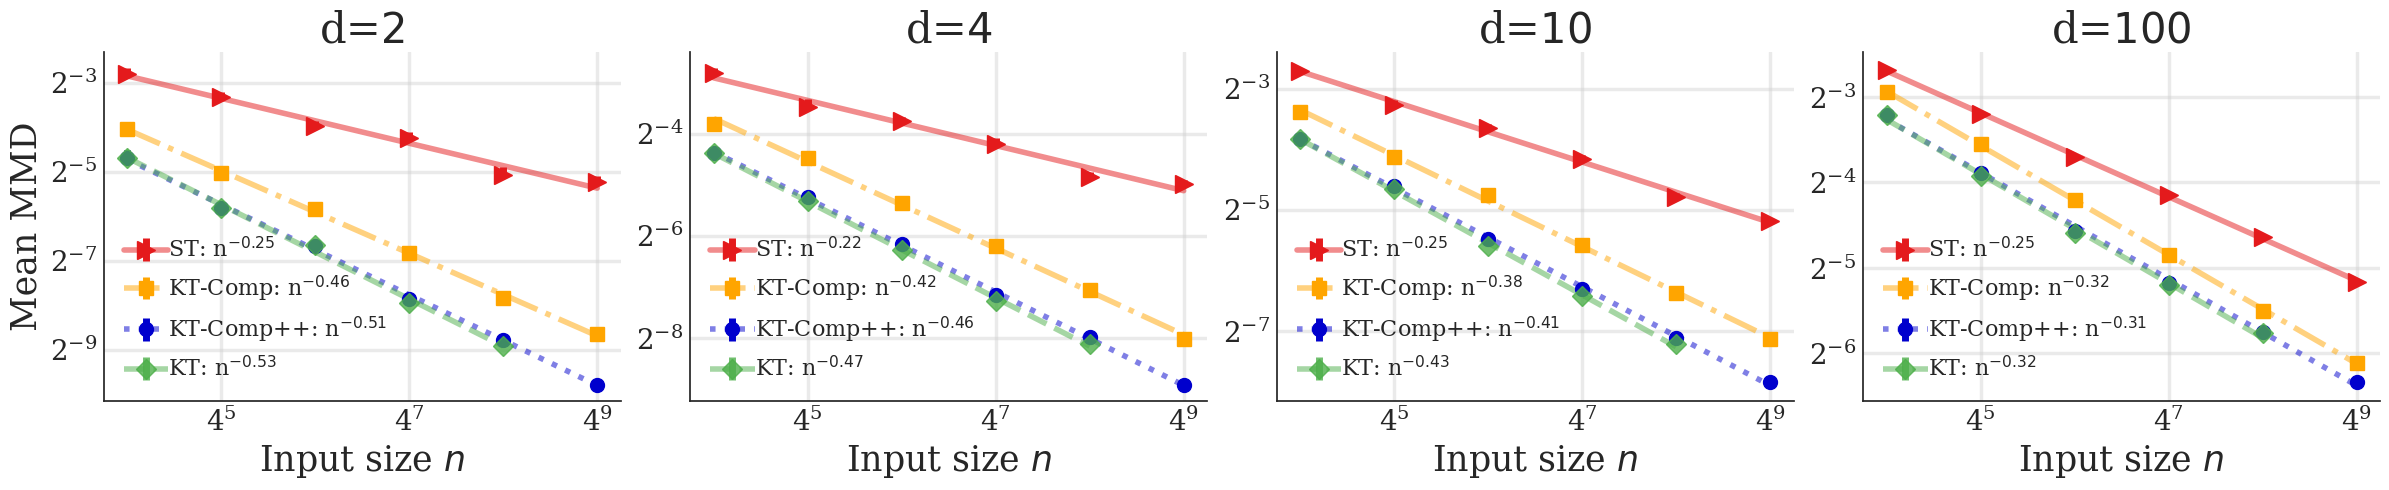

In [137]:

save_fig = False
if run_gauss_experiments:
    skip_ns = int(0)
    axes = plt.subplots(1, len(ds), figsize=[6*len(ds), 5], sharex=True, sharey=False)
    for i, d in enumerate(ds):
        ax = axes[1] if len(ds) == 1 else axes[1][i]
        simple_mmd_dict = post_process(combined_mmd_results[f'd_{d}'], args, plot_keys, adjust_g=adjust_g, 
                                       sizes_non_kt = sizes_non_kt, sizes_kt=sizes_kt)
        plot_mmd_dict_new(ax, range(args.size_min, args.size_max+1), simple_mmd_dict, 0.5, 
                      skip_ns=skip_ns, error_bar=True, rm_keys = [], change_cpthin=True, alpha_kt=.8,
                      legend_loc='lower left',
                      legend_size=16, adjust_g=adjust_g, 
                                       sizes_non_kt = sizes_non_kt, sizes_kt=sizes_kt, basex=basex, basey=basey)
        #ax.set_ylim([2**(-12), 2**(-2)])
        ax.set_title(r"d=$%d$"%(d), fontsize=title_size)
        if i==0:
            ax.set_ylabel(ylab, fontsize=ylab_size)
        ax.set_xlabel(r"Input size $n$", fontsize=xlab_size)
    plt.tight_layout()
    if save_fig:
        suff  = f"4_{sizes_non_kt[1]}" if adjust_g else ""
        if herding_coresets:
            plt.savefig(fig_dir + f"gauss_herd_mmd_{suff}.pdf")
        else:
            plt.savefig(fig_dir + f"gauss_kt_mmd_{suff}.pdf")

    plt.show()


## 1.2 Load and plot Herding results

In [54]:
### flags ####

st_coresets = True
kt_coresets = False
cpp_kt_coresets = False
herding_coresets = True
cpp_herding_coresets = True


### g and size parameters ###

adjust_g = True # only compress (g=0) and compress++ with g=4 will be loaded
sizes_kt = [4, 5] # sizes for kt results
sizes_non_kt = [4, 5] # sizes for non-kt results

if adjust_g is False: 
    sizes_kt = None
    sizes_non_kt = None

In [62]:
## load results ##

args = parse_arguments()

args.krt = 0 # 0 if no krt, anything else for krt

# mmd and size params
args.combine_mmd = 1  # whether to combine mmd
args.computemmd = 1 # whether to compute mmd; if set to 0, the code might behave weirdly
args.size_min, args.size_max = 4, 5
args.rep0 = 0
args.repn = 10
args.g_max = 4
args.symm1 = 1

# rerun/compute params
args.rerun = 0
args.recomputemmd = 0 # CHECK THIS

# recombine
args.recombine = False # whether to create a new combined mmd file in case one already exists

if run_gauss_experiments:
    args.setting = "gauss"
    for d in ds:
        args.d = d
        combined_mmd_results["d_%d"%d] = dict()
        
        # compute d, params_p and var_k for the setting
        d, params_p, var_k = compute_params_p(args)

        # define the kernels
        params_k_split, params_k_swap, _, _ = compute_params_k(d=d, var_k=var_k, 
                                                            use_krt_split=args.krt, name="gauss")
        flags = [st_coresets, cpp_kt_coresets, kt_coresets,  cpp_herding_coresets, herding_coresets]
        labels = ["ST", "CP+KT", "KT", "CPHerd", "Herd"]
        for f, lab in zip(flags, labels):
            if f:
                if adjust_g:
                    if lab == "KT" or lab == "Herd":
                        args.size_min, args.size_max = sizes_kt[0], sizes_kt[1]
                    else:
                        args.size_min, args.size_max = sizes_non_kt[0], sizes_non_kt[1]
                    
                args.cset = lab
                combined_mmd_results["d_%d"%d][lab] = dict()
                combined_mmd_results["d_%d"%d][lab] = combine_results(args, params_p, params_k_split, params_k_swap, adjust_g=adjust_g)

In [63]:
## set plotting keys ##
plot_keys = []
for f, lab in zip(flags, labels):
    if f:
        plot_keys.append(lab)
print(plot_keys)
basex = 4
basey = 2

['ST', 'CPHerd', 'Herd']


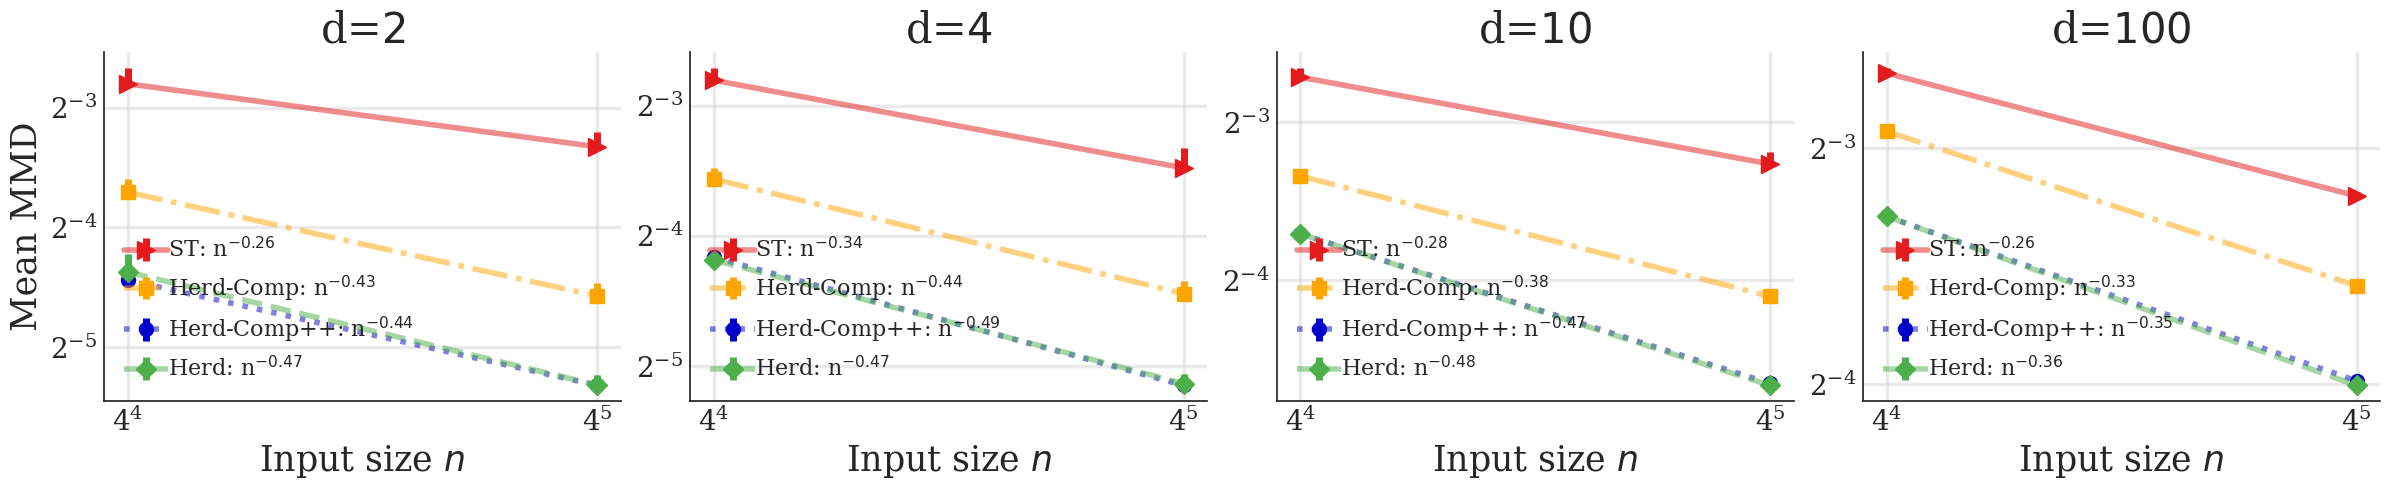

In [64]:

save_fig = False
if run_gauss_experiments:
    skip_ns = int(0)
    axes = plt.subplots(1, len(ds), figsize=[6*len(ds), 5], sharex=True, sharey=False)
    for i, d in enumerate(ds):
        ax = axes[1] if len(ds) == 1 else axes[1][i]
        simple_mmd_dict = post_process(combined_mmd_results[f'd_{d}'], args, plot_keys, adjust_g=adjust_g, 
                                       sizes_non_kt = sizes_non_kt, sizes_kt=sizes_kt)
        plot_mmd_dict_new(ax, range(args.size_min, args.size_max+1), simple_mmd_dict, 0.5, 
                      skip_ns=skip_ns, error_bar=True, rm_keys = [], change_cpthin=True, alpha_kt=.8,
                      legend_loc='lower left',
                      legend_size=16, adjust_g=adjust_g, 
                                       sizes_non_kt = sizes_non_kt, sizes_kt=sizes_kt, basex=basex, basey=basey)
        #ax.set_ylim([2**(-12), 2**(-2)])
        ax.set_title(r"d=$%d$"%(d), fontsize=title_size)
        if i==0:
            ax.set_ylabel(ylab, fontsize=ylab_size)
        ax.set_xlabel(r"Input size $n$", fontsize=xlab_size)
    plt.tight_layout()
    if save_fig:
        suff  = f"4_{sizes_non_kt[1]}" if adjust_g else ""
        if herding_coresets:
            plt.savefig(fig_dir + f"gauss_herd_mmd_{suff}.pdf")
        else:
            plt.savefig(fig_dir + f"gauss_kt_mmd_{suff}.pdf")
    plt.show()


# 2. MOG Results

## 2.1 MOG KT results

In [20]:
### flags ####

st_coresets = False ####
kt_coresets = True
cpp_kt_coresets = True
herding_coresets = False
cpp_herding_coresets = False


### g and size parameters ###

adjust_g = True # only compress (g=0) and compress++ with g=4 will be loaded
sizes_kt = [4, 5] # sizes for kt and herding results
sizes_non_kt = [4, 5] # sizes for compress++ results

if adjust_g is False: 
    sizes_kt = None
    sizes_non_kt = None

In [28]:
args = parse_arguments()

args.krt = 0 # 0 if no krt, anything else for krt

# mmd and size params
args.combine_mmd = 1 
args.computemmd = 1
args.size_min, args.size_max = 4, 5
args.rep0 = 0
args.repn = 2
args.g_max = 4
args.symm1 = 1

# rerun/compute params
args.rerun = 0
args.recomputemmd = 0 # CHECK THIS

# recombine
args.recombine = False # whether to create a new combined mmd file in case one already exists

if run_mog_experiments:
    args.setting = "mog"
    args.d = 2
    d = args.d
    for M in Ms:
        args.M = M
        combined_mmd_results["M_%d"%M] = dict()
        
        # compute d, params_p and var_k for the setting
        _, params_p, var_k = compute_params_p(args)
        
        
        # define the kernels
        params_k_split, params_k_swap, _, _ = compute_params_k(d=d, var_k=var_k, 
                                                            use_krt_split=args.krt, name="gauss")
        
        flags = [st_coresets, cpp_kt_coresets, kt_coresets,  cpp_herding_coresets, herding_coresets]
        labels = ["ST", "CP+KT", "KT", "CPHerd", "Herd"]
        for f, lab in zip(flags, labels):
            if f:
                if adjust_g:
                    if lab == "KT" or lab == "Herd":
                        args.size_min, args.size_max = sizes_kt[0], sizes_kt[1]
                    else:
                        args.size_min, args.size_max = sizes_non_kt[0], sizes_non_kt[1]
                # print(lab)
                args.cset = lab
                combined_mmd_results["M_%d"%M][lab] = dict()
                combined_mmd_results["M_%d"%M][lab] = combine_results(args, params_p, params_k_split, params_k_swap, adjust_g=adjust_g)
        

In [29]:
plot_keys = []
for f, lab in zip(flags, labels):
    if f:
        plot_keys.append(lab)

print(plot_keys)

basex = 4
basey = 4

['CP+KT', 'KT']


TypeError: LogScale.__init__() got an unexpected keyword argument 'basex'

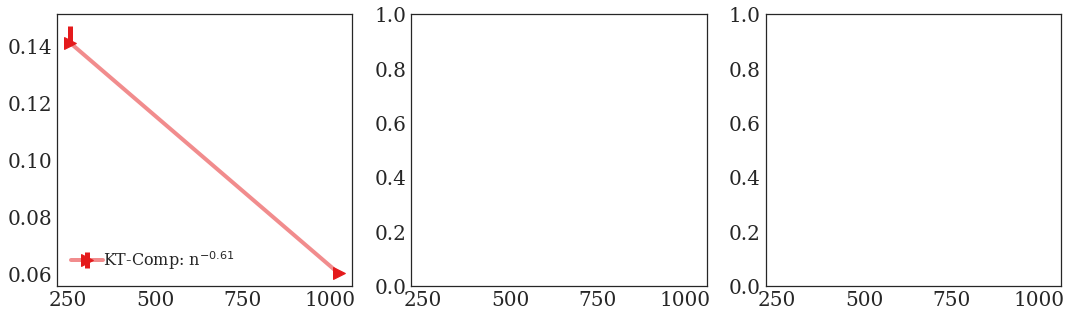

In [30]:
save_fig = False
rm_keys = ["CPHerd-1", "CPHerd-2", "CPHerd-3"] # if other g results were loaded
if run_mog_experiments:
    skip_ns = int(0)
    axes = plt.subplots(1, len(Ms), figsize=[6*len(Ms), 5], sharex=True, sharey=False)
    for i, M in enumerate(Ms):
        ax = axes[1] if len(Ms) == 1 else axes[1][i]
        simple_mmd_dict = post_process(combined_mmd_results[f'M_{M}'], args, plot_keys, adjust_g=adjust_g, 
                                       sizes_non_kt = sizes_non_kt, sizes_kt=sizes_kt)
        plot_mmd_dict_new(ax, range(args.size_min, args.size_max+1), simple_mmd_dict, 0.5, 
                      skip_ns=skip_ns, error_bar=True, rm_keys = rm_keys, change_cpthin=True, alpha_kt=0.6,
                      legend_loc='lower left',
                      legend_size=16, adjust_g=adjust_g, 
                                       sizes_non_kt = sizes_non_kt, sizes_kt=sizes_kt, basex=basex, basey=basey)
        #ax.set_ylim([2**(-12), 2**(-2)])
        ax.set_title(r"M=$%d$"%(M), fontsize=title_size)
        if i==0:
            ax.set_ylabel(ylab, fontsize=ylab_size)
        ax.set_xlabel(r"Input size $n$", fontsize=xlab_size)
    plt.tight_layout()
    if save_fig:
        suff  = f"4_{sizes_non_kt[1]}" if adjust_g else ""
        if herding_coresets:
            print(f"saving to mog_herd_mmd_{suff}.pdf")
            plt.savefig(fig_dir + f"mog_herd_mmd_{suff}.pdf")
        else:
            print(f"saving to mog_kt_mmd_{suff}.pdf")
            plt.savefig(fig_dir + f"mog_kt_mmd_{suff}.pdf")
    plt.show()


## 2.2 MOG Herding Results

In [111]:
### flags ####

st_coresets = True
kt_coresets = False
cpp_kt_coresets = False
herding_coresets = True
cpp_herding_coresets = True


### g and size parameters ###

adjust_g = True # only compress (g=0) and compress++ with g=4 will be loaded
sizes_kt = [4, 5] # sizes for kt and herding results
sizes_non_kt = [4, 5] # sizes for compress++ results

if adjust_g is False: 
    sizes_kt = None
    sizes_non_kt = None

In [176]:
args = parse_arguments()

args.krt = 0 # 0 if no krt, anything else for krt

# mmd and size params
args.combine_mmd = 1 
args.computemmd = 1
args.size_min, args.size_max = 4, 5
args.rep0 = 0
args.repn = 2
args.g_max = 4
args.symm1 = 1

# rerun/compute params
args.rerun = 0
args.recomputemmd = 0 # CHECK THIS

# recombine
args.recombine = False # whether to create a new combined mmd file in case one already exists

if run_mog_experiments:
    args.setting = "mog"
    args.d = 2
    d = args.d
    for M in Ms:
        args.M = M
        combined_mmd_results["M_%d"%M] = dict()
        
        # compute d, params_p and var_k for the setting
        _, params_p, var_k = compute_params_p(args)
        
        
        # define the kernels
        params_k_split, params_k_swap, _, _ = compute_params_k(d=d, var_k=var_k, 
                                                            use_krt_split=args.krt, name="gauss")
        
        flags = [st_coresets, cpp_kt_coresets, kt_coresets,  cpp_herding_coresets, herding_coresets]
        labels = ["ST", "CP+KT", "KT", "CPHerd", "Herd"]
        for f, lab in zip(flags, labels):
            if f:
                if adjust_g:
                    if lab == "KT" or lab == "Herd":
                        args.size_min, args.size_max = sizes_kt[0], sizes_kt[1]
                    else:
                        args.size_min, args.size_max = sizes_non_kt[0], sizes_non_kt[1]
                # print(lab)
                args.cset = lab
                combined_mmd_results["M_%d"%M][lab] = dict()
                combined_mmd_results["M_%d"%M][lab] = combine_results(args, params_p, params_k_split, params_k_swap, adjust_g=adjust_g)
        

In [113]:
plot_keys = []
for f, lab in zip(flags, labels):
    if f:
        plot_keys.append(lab)

print(plot_keys)

basex = 4
basey = 4

['ST', 'CPHerd', 'Herd']


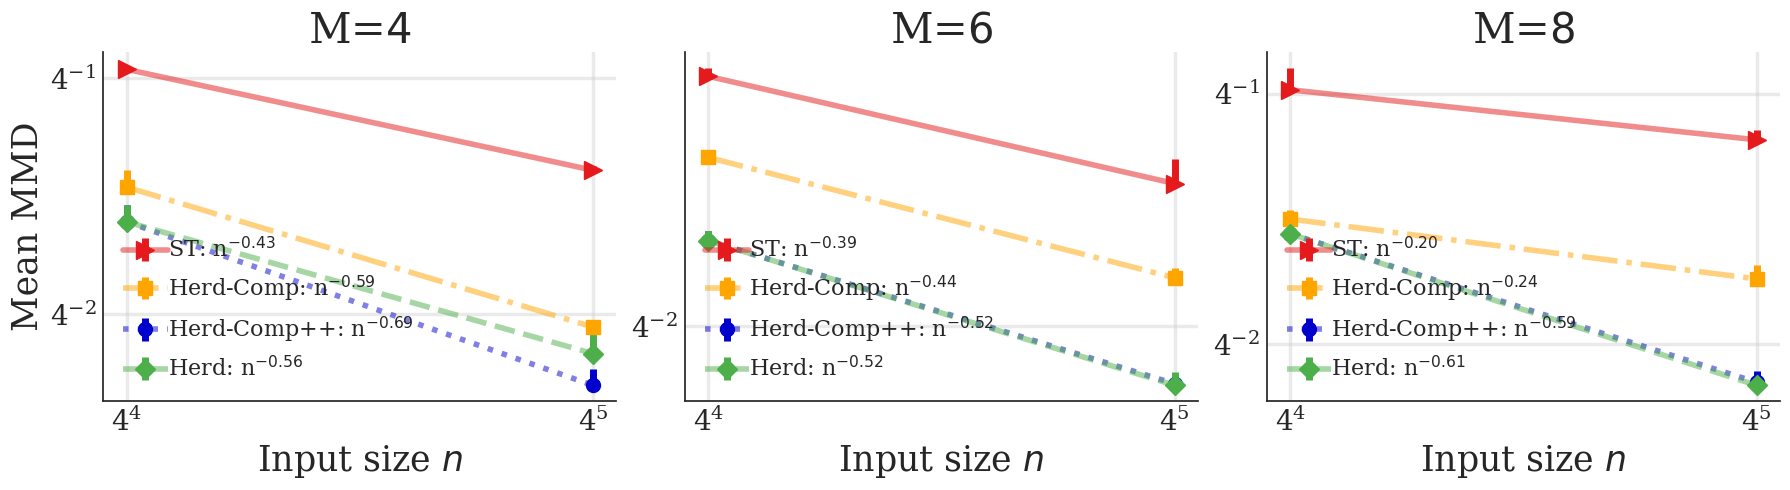

In [114]:
save_fig = False
rm_keys = ["CPHerd-1", "CPHerd-2", "CPHerd-3"] # if other g results were loaded
if run_mog_experiments:
    skip_ns = int(0)
    axes = plt.subplots(1, len(Ms), figsize=[6*len(Ms), 5], sharex=True, sharey=False)
    for i, M in enumerate(Ms):
        ax = axes[1] if len(Ms) == 1 else axes[1][i]
        simple_mmd_dict = post_process(combined_mmd_results[f'M_{M}'], args, plot_keys, adjust_g=adjust_g, 
                                       sizes_non_kt = sizes_non_kt, sizes_kt=sizes_kt)
        plot_mmd_dict_new(ax, range(args.size_min, args.size_max+1), simple_mmd_dict, 0.5, 
                      skip_ns=skip_ns, error_bar=True, rm_keys = rm_keys, change_cpthin=True, alpha_kt=0.6,
                      legend_loc='lower left',
                      legend_size=16, adjust_g=adjust_g, 
                                       sizes_non_kt = sizes_non_kt, sizes_kt=sizes_kt, basex=basex, basey=basey)
        #ax.set_ylim([2**(-12), 2**(-2)])
        ax.set_title(r"M=$%d$"%(M), fontsize=title_size)
        if i==0:
            ax.set_ylabel(ylab, fontsize=ylab_size)
        ax.set_xlabel(r"Input size $n$", fontsize=xlab_size)
    plt.tight_layout()
    if save_fig:
        suff  = f"4_{sizes_non_kt[1]}" if adjust_g else ""
        if herding_coresets:
            print(f"saving to mog_herd_mmd_{suff}.pdf")
            plt.savefig(fig_dir + f"mog_herd_mmd_{suff}.pdf")
        else:
            print(f"saving to mog_kt_mmd_{suff}.pdf")
            plt.savefig(fig_dir + f"mog_kt_mmd_{suff}.pdf")
    plt.show()


## 2.3 Scatter plot of 32-MOG 

In [115]:
from util_sample import compute_diag_mog_params

In [116]:
parser = init_parser()
args, opt = parser.parse_known_args()

In [119]:
d = 2
var =  float(2*d)
params_k = {"name": "gauss", "var": var, "d": int(d)}
M = 32
params_p = compute_diag_mog_params(M)
args.setting = 'mog'
args.M = M

args.returncoreset =1
args.rep0 = 4
args.repn = 1
args.rerun = 0


args.symm1 = 1
m_plots = range(5, 7)

g_pp = 4
assert(g_pp <= min(m_plots))

args.g = g_pp


In [120]:
Xs = dict()

for m in m_plots:
    args.m, args.size = m, m
    Xs[m] = dict()
    
    Xs[m]["i.i.d."], Xs[m]["KT"] = construct_kt_coresets(args)
    _, Xs[m]["Herd"] = construct_herding_coresets(args)
    
    args.compressalg = "kt"
    _, Xs[m]["KT-Comp++"] = construct_compresspp_coresets(args)
    
    args.compressalg = "herding"
    _, Xs[m]["Herd-Comp++"] = construct_compresspp_coresets(args)
    
    
    
    

Running KT experiment with template coresets_folder/KT-coresets-diag_mog_comp32_seed290478664-splitgauss_var4.000_thinseed892970928-swapgauss_var4.000-d2-sz5-m5-delta0.5-rep4.pkl.....
(re) Generating coreset
-elapsed time: 1.41 (s)
Running herding experiment with template coresets_folder/Herd-coresets-diag_mog_comp32_seed290478664-swapgauss_var4.000-d2-sz5-m5-rep4.pkl.....
(re) Generating coreset
-elapsed time: 0.156 (s)
Running Compress++ experiment with template coresets_folder/Compresspp-symm1--coresets-diag_mog_comp32_seed290478664-splitgauss_var4.000-swapgauss_var4.000-algkt-alpha4-compressseed2640736309-d2-sz5-delta0.5-rep4.pkl.....
(re) Generating coreset
-elapsed time: 1.39 (s)
Running Compress++ experiment with template coresets_folder/Compresspp-symm1--coresets-diag_mog_comp32_seed290478664-splitgauss_var4.000-swapgauss_var4.000-algherding-alpha4-compressseed2640736309-d2-sz5-delta0.5-rep4.pkl.....
(re) Generating coreset
-elapsed time: 0.267 (s)
Running KT experiment with te

In [121]:
lss = ['-', '-.',  ':', '--',  '--', '-.', ':', '-', '--', '-.', ':', '-']*2
mss = ['>', 's', 'o', 'D', '+', '*',  '>', 's', 'o', 'D', '>', 's', 'o', 'D']*2
ms_size = [25, 20, 20, 20, 50, 40, 20, 20, 20, 20]
colors = ['#e41a1c', 'cyan',   '#0000cd',   '#4daf4a', 'magenta', 'black' ,'orange','yellow','gray']*2
colors = ['#e41a1c', #red
          'orange',  
          '#0000cd', #blue
            '#4daf4a', #green
          'magenta', 'black' , 'olive']*2
ms_factor = 2.

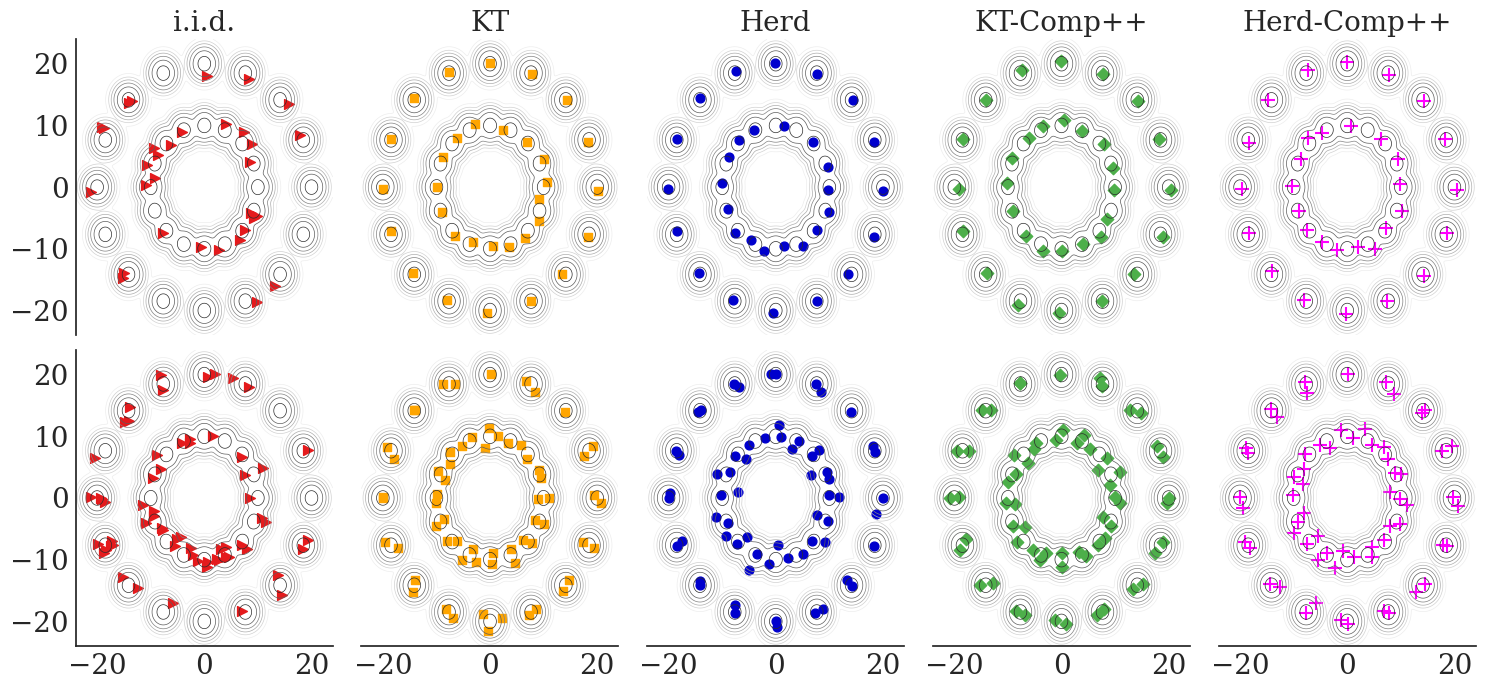

In [122]:
save_fig = False

contour = True
# use contour (True) lines or filled contour plot (False)

for M in [32]:
    params_p = compute_diag_mog_params(M)
    snr = 2*max(params_p["covs"])
    if M == 4:
        snr *= 2.5
    else:
        snr *= 2
    lim0 = np.min(params_p["means"])-snr
    lim1 = np.max(params_p["means"])+snr
    x, y = np.mgrid[lim0:lim1:.05, lim0:lim1:.05]
    pos = np.dstack((x, y))
    # compute pdf of the diag MOg density
    for i in range(M):
        rv_object = multivariate_normal(params_p["means"][i], np.eye(d) * params_p["covs"][i])
        if i == 0:
            density = params_p["weights"][i]*rv_object.pdf(pos)
        else:
            density += params_p["weights"][i]*rv_object.pdf(pos)

    a, b = len(m_plots), len(Xs[m])
    axes = plt.subplots(a, b, figsize=[3*b, 3.5*a], sharex=True, sharey=True)    

    for i, m in enumerate(m_plots): 
        n = int(2**m)
        for j, (label, X) in enumerate(Xs[m].items()):
            ax = axes[1][i][j]
            # plot density of the MoG
            if contour:
                C = ax.contour(x, y, np.log(density+np.exp(-14)), cmap="Greys", linewidths=.5)
                # ax.clabel(C, inline=1, fontsize=10)
            else:
                ax.contourf(x, y, np.log(density+np.exp(-20)), cmap="Greys")
            # scatter plot
            if label == "i.i.d.":
                # do standard thinning of the iid points
                step = int(X.shape[0]/n)
                ax.scatter(X[step-1:X.shape[0]:step, 0], X[step-1:X.shape[0]:step, 1], marker=mss[j], s=ms_size[j]*ms_factor,  color=colors[j], label=label)
            else:
                #print(j, X)
                ax.scatter(X[:n, 0], X[:n, 1], marker=mss[j], s=ms_size[j]*ms_factor,  color=colors[j], label=label)

            ax.spines['top'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['right'].set_visible(False)
            # ax.spines['bottom'].set_visible(False)
            if i == 0:
                ax.set_title(f"{label}", fontsize=20)
            if i < a-1:
                ax.spines['bottom'].set_visible(False)
            if j == 0:
                ax.spines['left'].set_visible(True)

#             ax.set_title(f"{n} {label} points", fontsize=10)
#             if j==0:
#                 ax.spines['left'].set_visible(True)
#             if j==len(Xs)-1:
#                 ax.spines['bottom'].set_visible(True)
    
    plt.tight_layout()
    if save_fig:
        plt.savefig(fig_dir+f"mog_8_scatter_{args.rep0}_{M}_no_comp.pdf")
    plt.show()

# 3.MCMC results

In [100]:
def mcmc_titles(a):
    # function to reformat titles for figures corresponding to Hinch data with filename starting with a
    a = a.replace("_P_", " ")
    a = a.replace("_TP_", " Tempered ")
    a = a.replace("seed_1", "RW 1")
    a = a.replace("seed_2", "RW 2")
    a = a.replace("_temp_1", "")
    a = a.replace("_temp_8", "")
    a = a.replace("_scaled", "")
    a = a.replace("_float_step", "")
    a = a.replace("_nosplit","")
    a = a.replace("_", " ")
    a = a.replace("Lotka", "Lotka-Volterra")
    a = a.replace("PRECOND-", "p")
    a = a.replace("Hinch Tempered", "Tempered Hinch")
#     a += ")"
    return(a)

In [101]:
### flags ####

st_coresets = True
kt_coresets = True
cpp_kt_coresets = True
herding_coresets = False
cpp_herding_coresets = False


### g and size parameters ###

adjust_g = True # only compress (g=0) and compress++ with g=4 will be loaded
sizes_kt = [4, 7] # sizes for kt and herding results
sizes_non_kt = [4, 7] # sizes for compress++ results

if adjust_g is False: 
    sizes_kt = None
    sizes_non_kt = None

In [102]:
run_mcmc_experiments = True

In [103]:
args = parse_arguments()
args.mcmcfolder = "/accounts/projects/binyu/raaz.rsk/kernel_thinning/kernel_thinning_plus/data"
args.krt = 0 # 0 if no krt, anything else for krt

# mmd and size params
args.combine_mmd = 1 
args.computemmd = 1
args.size_min, args.size_max = 4, 5
args.rep0 = 0
args.repn = 10
args.g_max = 4
args.symm1 = 1

# rerun/compute params
args.rerun = 0
args.recomputemmd = 0 # CHECK THIS

# recombine
args.recombine = False # whether to create a new combined mmd file in case one already exists


if run_mcmc_experiments:
    args.setting = "mcmc"
    for filename in all_mcmc_filenames: ### CHANGE THE LIST to all_mcmc_filenames when running all experiments ###
        args.filename = filename
        combined_mmd_results[filename] = dict()
        
        # compute d, params_p and var_k for the setting
        d, params_p, var_k = compute_params_p(args)
        args.d  = d 
        
        # define the kernels
        params_k_split, params_k_swap, _, _ = compute_params_k(d=d, var_k=var_k, 
                                                            use_krt_split=args.krt, name="gauss")
        
        flags = [st_coresets, cpp_kt_coresets, kt_coresets,  cpp_herding_coresets, herding_coresets]
        labels = ["ST", "CP+KT", "KT", "CPHerd", "Herd"]
        for f, lab in zip(flags, labels):
            if f:
                if adjust_g:
                    if lab == "KT" or 'Hinch' in args.filename or 'Lotka_ADA-RW' in args.filename:
                        args.size_min, args.size_max = sizes_kt[0], sizes_kt[1]
                    else:
                        args.size_min, args.size_max = sizes_non_kt[0], sizes_non_kt[1]
                args.cset = lab
                combined_mmd_results[filename][lab] = dict()
                combined_mmd_results[filename][lab] = combine_results(args, params_p, params_k_split, params_k_swap, adjust_g=adjust_g)

In [114]:
for m in [4, 5, 6, 7]:
    print(combined_mmd_results['Lotka_ADA-RW']["KT"]["KT"][f'size_{m}'].mean())

0.01921274081005445
0.010247551638082728
0.004942488819583054
0.0025017586677775574


In [105]:
plot_keys = []
for f, lab in zip(flags, labels):
    if f:
        plot_keys.append(lab)

print(plot_keys)

['ST', 'CP+KT', 'KT']


In [106]:
basex = 4
basey = 2
title_size = 25

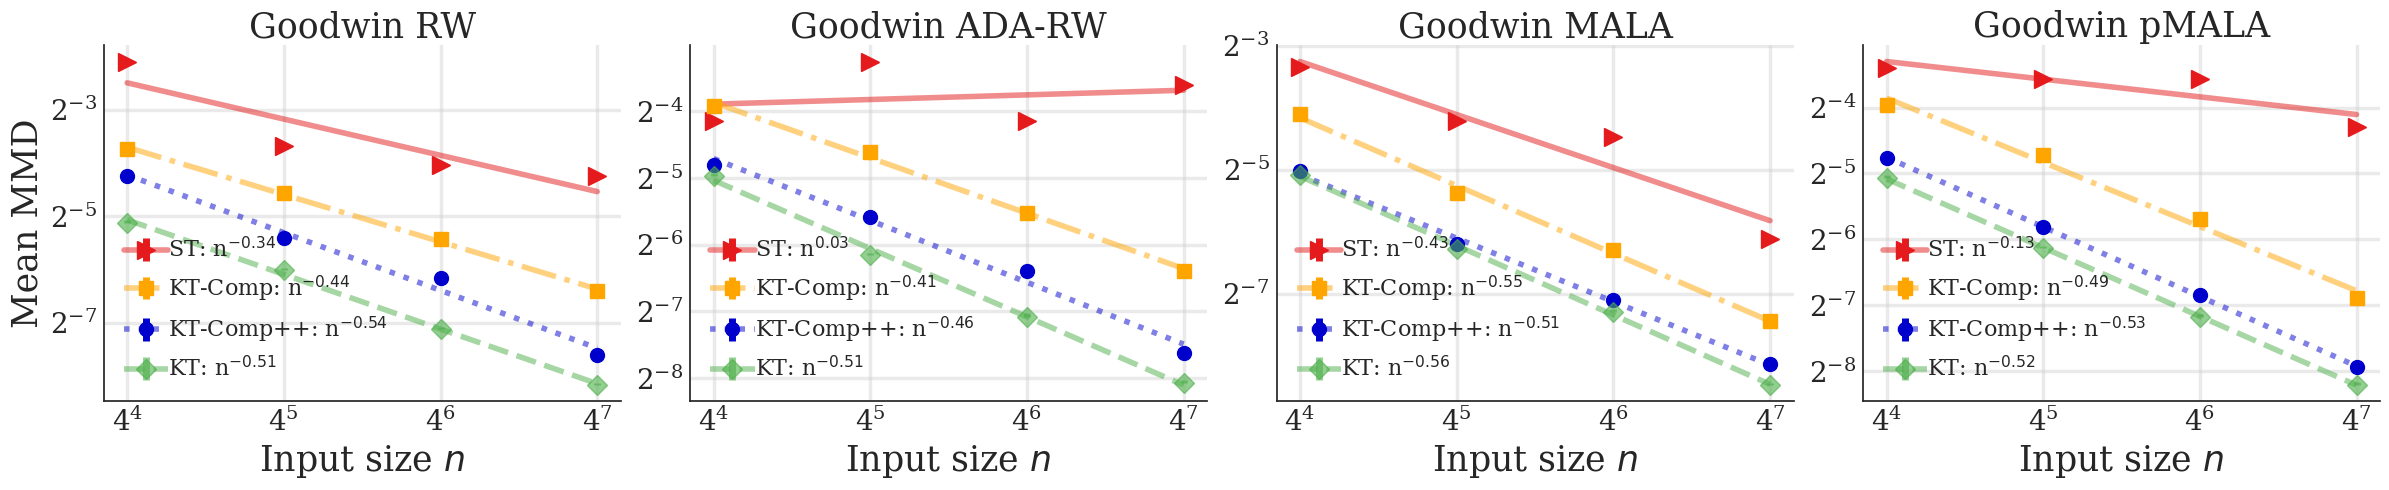

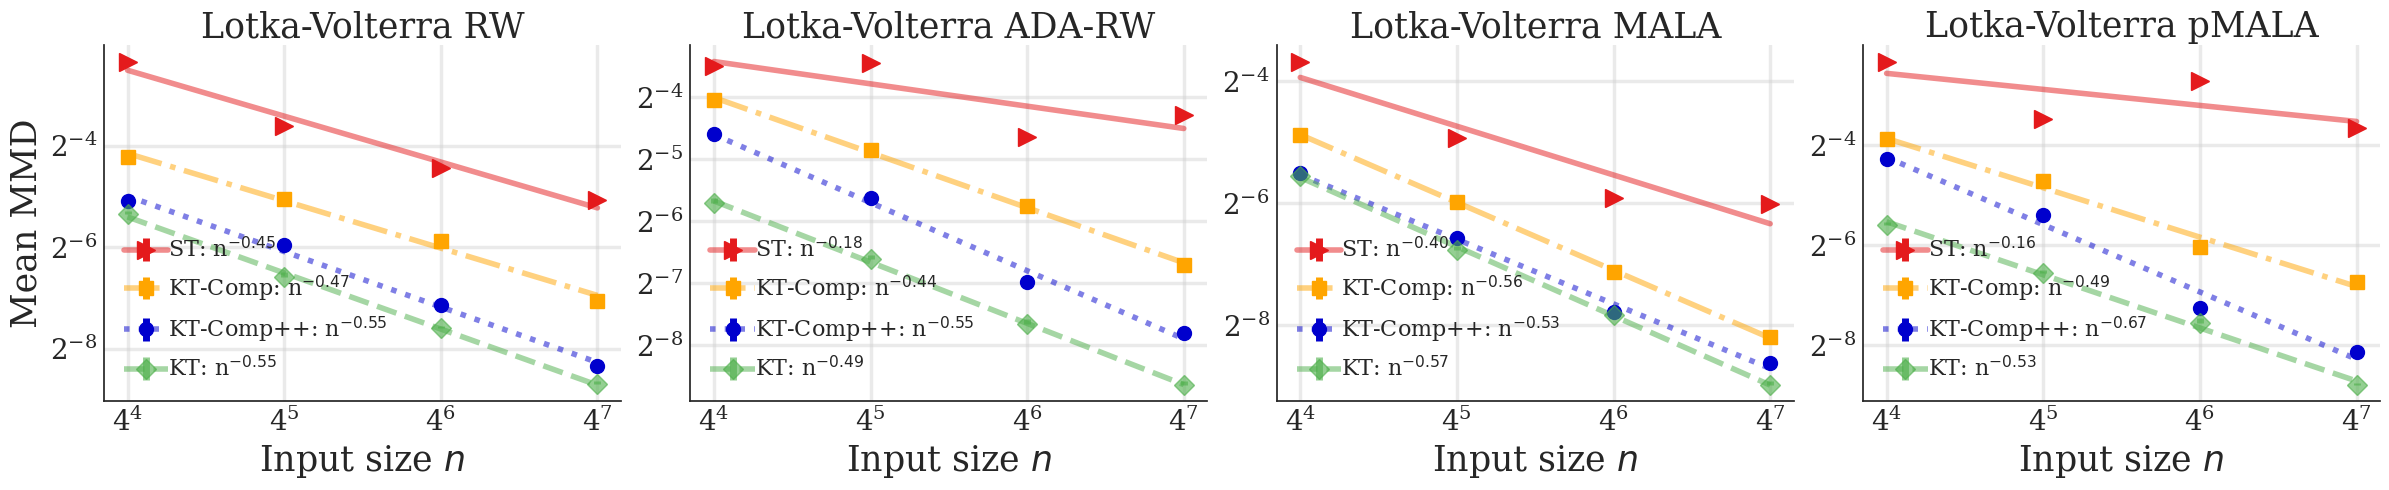

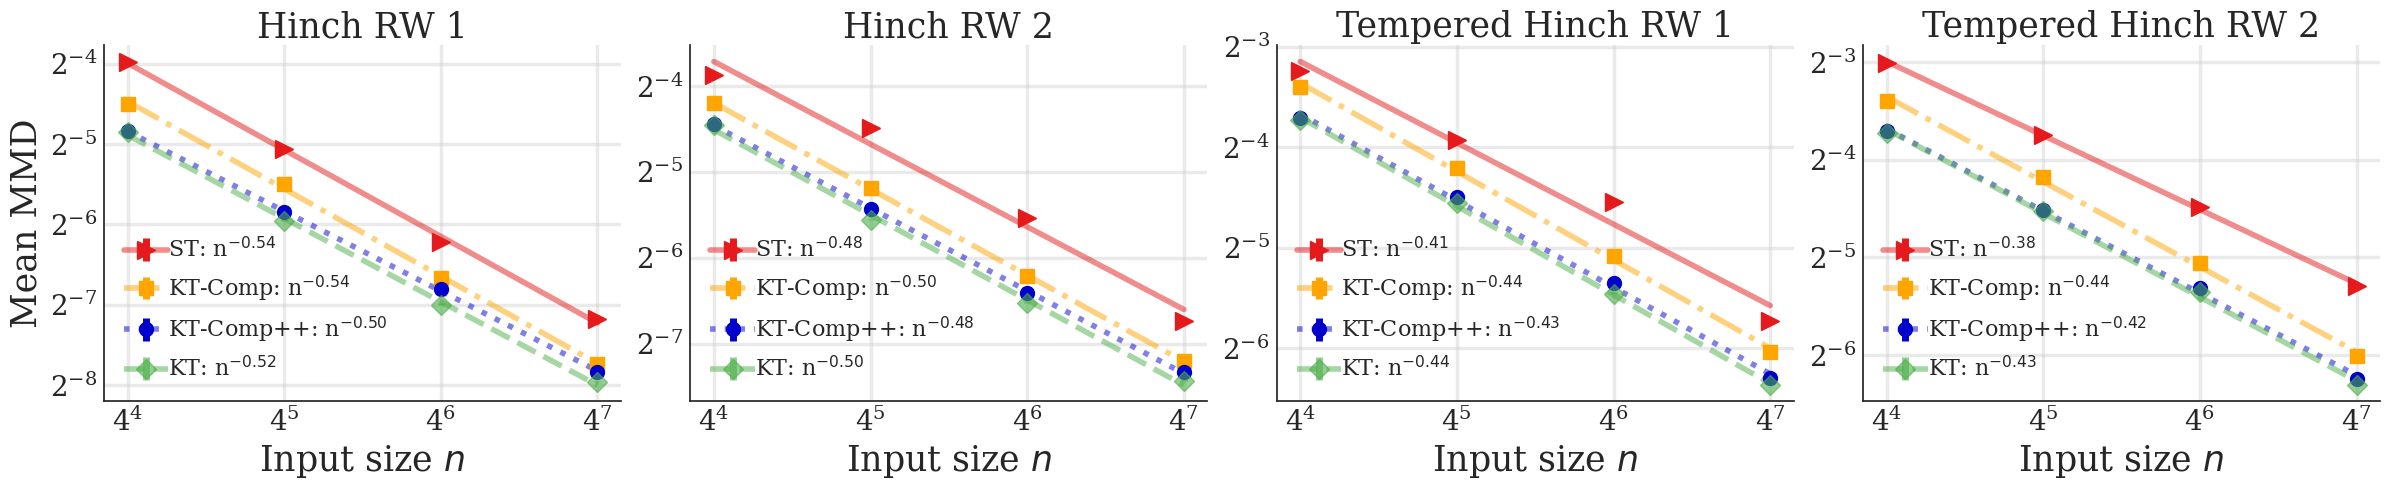

In [107]:
save_fig = False
if run_mcmc_experiments:
    for t in [0, 4, 8]: ### NOTE CHANGE TO [0, 4, 8] WHEN RUNNING ALL MCMC EXPERIMENTS
        if t == 8 and adjust_g:
            sizes_non_kt = sizes_kt.copy()
        plot_files = np.array(all_mcmc_filenames)[range(t, t+4)]
        simplified_plot = True
        if simplified_plot:
            skip_ns = int(0)
            axes = plt.subplots(1, len(plot_files), figsize=[6*len(plot_files), 5], sharex=False, sharey=False)
            for i, filename in enumerate(plot_files):
                if ((filename == "Lotka_ADA-RW") or ("Hinch" in filename) )and sizes_kt[1]>8:
                    sizes_kt[1] = 8
                    sizes_non_kt[1] = 8
                if sizes_kt[1]>8:
                    sizes_kt[1] = 8
                ax = axes[1] if len(plot_files) == 1 else axes[1][i]
                simple_mmd_dict = post_process(combined_mmd_results[filename], args, plot_keys, adjust_g=adjust_g, 
                                           sizes_non_kt = sizes_non_kt, sizes_kt=sizes_kt)
                plot_mmd_dict_new(ax, range(args.size_min, args.size_max+1), simple_mmd_dict, 0.5, 
                          skip_ns=skip_ns, error_bar=True, rm_keys = [], change_cpthin=True, alpha_kt=0.6,
                          legend_loc='lower left',
                          legend_size=16, adjust_g=adjust_g, 
                                           sizes_non_kt = sizes_non_kt, sizes_kt=sizes_kt, basex=basex, basey=basey)
                #ax.set_ylim([2**(-12), 2**(-2)])
                ax.set_title(mcmc_titles(filename), fontsize=title_size)
                ax.set_xticks([4**i for i in range(sizes_non_kt[0], sizes_non_kt[1]+1)])
                if i==0:
                    ax.set_ylabel(ylab, fontsize=ylab_size)
                ax.set_xlabel(r"Input size $n$", fontsize=xlab_size)
            plt.tight_layout()
            if save_fig:
                suff  = "4_9" if adjust_g else ""
                plt.savefig(fig_dir + f"mcmc_{plot_files[0][:4]}_kt_mmd_{suff}.pdf")
            plt.show()


# 4. Run-Time plots

In [71]:
from run_time import run_time 

## 4.1 KT results

In [79]:
## load results ##

args = parse_arguments()
args.rerun = 0
args.krt = 0 # 0 if no krt, anything else for krt
args.rep0 = 0
args.repn = 3 # number of reps kept to 3 here
args.symm1 = 1
args.verbose = 0

args.setting = "gauss"

args.resultfolder = "results/run_time"
size_time = range(4, 6)
gs = [0, 4]
d_time = [2, 4, 10, 100]

kt_times = np.zeros((len(d_time), len(size_time), args.repn))
cpp_kt_times = np.zeros((len(d_time),len(gs), len(size_time), args.repn))


for i, d in enumerate(d_time):
    for j, size in enumerate(size_time):
        args.d = d
        args.size = size
        args.thinalg = "kt"

        kt_times[i, j, :] = run_time(args)
        
        args.thinalg = "compresspp"
        args.compressalg = "kt"
        for a, g in enumerate(gs):
            args.g = g
            cpp_kt_times[i, j, a, :] = run_time(args)

Running runtime experiments reps [0 1 2] for d = 2, size = 4, alg = kt 
-elapsed time: 0.00361 (s)
Running runtime experiments reps [0 1 2] for d = 2, size = 4, alg = compresspp , compress_alg = kt
-elapsed time: 0.00352 (s)
Running runtime experiments reps [0 1 2] for d = 2, size = 4, alg = compresspp , compress_alg = kt
-elapsed time: 0.00354 (s)
Running runtime experiments reps [0 1 2] for d = 2, size = 5, alg = kt 
-elapsed time: 0.00373 (s)
Running runtime experiments reps [0 1 2] for d = 2, size = 5, alg = compresspp , compress_alg = kt
-elapsed time: 0.00357 (s)
Running runtime experiments reps [0 1 2] for d = 2, size = 5, alg = compresspp , compress_alg = kt
-elapsed time: 0.00367 (s)
Running runtime experiments reps [0 1 2] for d = 4, size = 4, alg = kt 
-elapsed time: 0.00352 (s)
Running runtime experiments reps [0 1 2] for d = 4, size = 4, alg = compresspp , compress_alg = kt
-elapsed time: 0.00366 (s)
Running runtime experiments reps [0 1 2] for d = 4, size = 4, alg = compr

In [80]:
lss = ['--', ':',  '-.', '--',  '--', '-.', ':', '-', '--', '-.', ':', '-']*2
mss = ['D', 'o', 's', 'D', '+', '*',  '>', 's', 'o', 'D', '>', 's', 'o', 'D']*2
ms_size = [25, 20, 20, 20, 20, 20, 20, 20, 20, 20]
colors = ['#4daf4a', #green
          '#0000cd', #blue
          'orange',  
          '#e41a1c', #red
          'magenta', 'black' , 'yellow','gray']*2

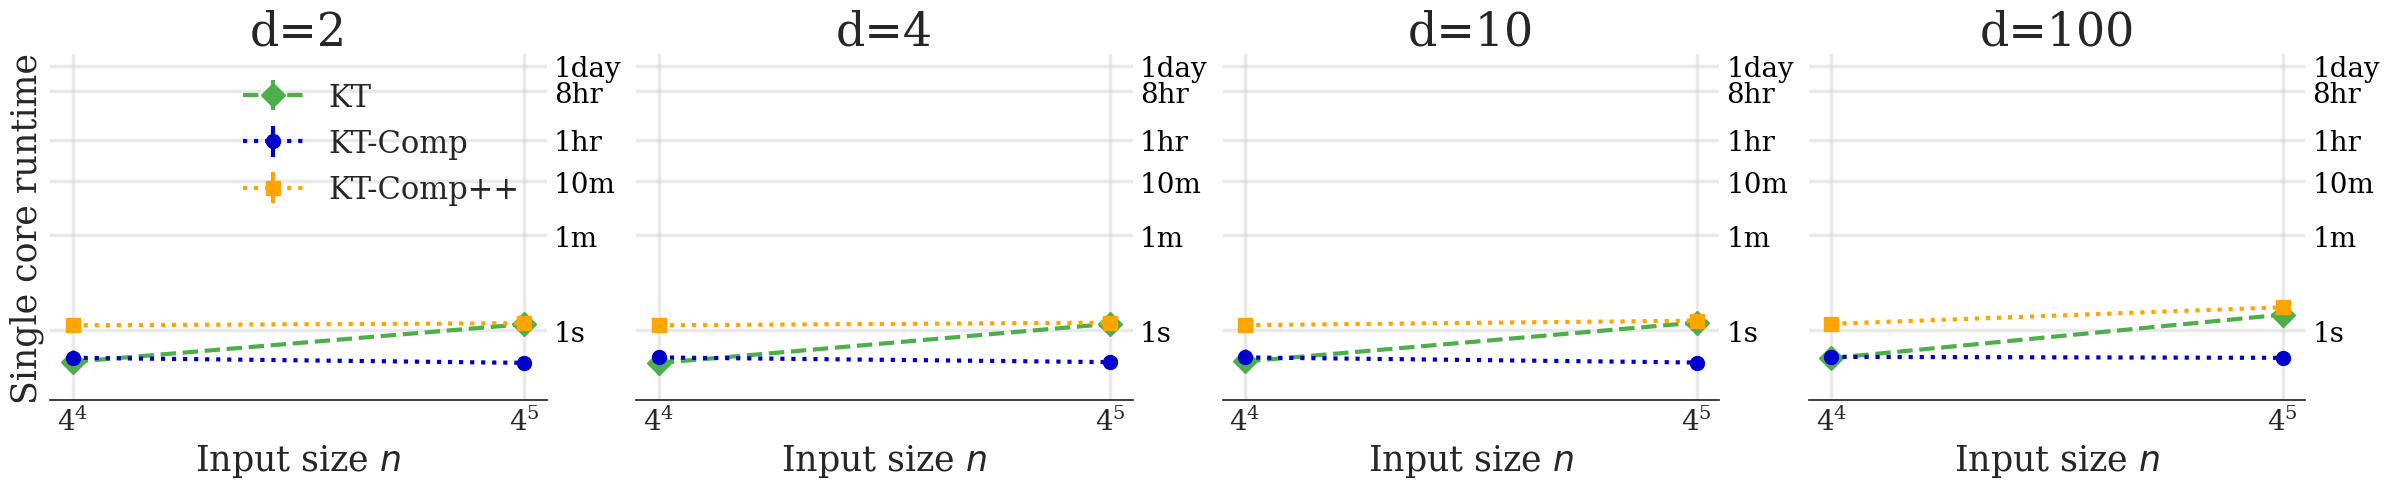

In [95]:
savefig = False
for ylog in [True]:
    axes = plt.subplots(1, len(d_time), figsize=[6*len(d_time), 5], sharex=True, sharey=False)
    for i, d, in enumerate(d_time):
        ax = axes[1][i]
        
        y =  kt_times[i, :, :].mean(1)
        yerr =  2*kt_times[i, :, :].std(1) / np.sqrt(args.repn)
        ax.errorbar(4**np.array(size_time[:]), y[:], marker=mss[0], 
                yerr=yerr[:], #np.array([-yerr, yerr]),
                linestyle=lss[0], markersize=ms_size[0]/2, color=colors[0], linewidth =3,
                 label='KT')
        for a, g in enumerate(gs): #range(0, min(g_max, size)+1):
            y = cpp_kt_times[i, a, :, :].mean(1)
            yerr = cpp_kt_times[i, a, :, :].std(1) / np.sqrt(args.repn)
            if g == 0:
                lab = "KT-Comp"
            else:
                lab = 'KT-Comp++'
            ax.errorbar(4**np.array(size_time), y, yerr=np.array([-yerr, yerr]),
                    marker=mss[1+a], linestyle=lss[jj+1], markersize=ms_size[1+a]/2,
                    color=colors[1+a], linewidth = 3,
    #                 linestyle='--', 
                    label=lab)
        ax.set_xscale('log', basex=10)
        if ylog:
            ax.set_yscale('log', basey=10)
            ax.set_ylim([5*1e-2, 1.4e5])
            ax.yaxis.tick_right()
            ax.set_yticks([1, 60, 600, 3600, 28800, 86400])
            ax.set_yticklabels( ['1s','1m', '10m', '1hr', '8hr', '1day'], fontsize=20, color='black')
        # ax.set_xticks([10**2, 10**3, 10**4])#
        ax.set_xlabel(r'Input size $n$', fontsize=xlab_size)

        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xscale('log', basex=4)
        # ax.spines['bottom'].set_visible(False)a
        
        ax.grid(True, alpha=0.4)
        ax.set_title("d=%d"%d, fontsize=1.1*title_size)
        if i == 0:
#             locs, labels = ax.get_yticks()  
#             ax.set_yticks([1, 60, 600, 3600, 36000, 86400])
            ax.set_ylabel('Single core runtime',fontsize=ylab_size)
            ax.legend(fontsize=22)
    plt.tight_layout()
    if savefig:
#         plt.savefig(fig_dir + "time_kt_1M.pdf")
        plt.savefig(fig_dir + "time_kt.pdf")
    plt.show()

In [89]:
for i, d, in enumerate(d_time):
    print(d, kt_times[i, :, :].mean(1) / cpp_kt_times[i, 1, :, :].mean(1), kt_times[i, :, :].mean(1),  cpp_kt_times[i, 1, :, :].mean(1))

2 [0.20880719 0.9601868 ] [0.26012273 1.31088506] [1.24575562 1.36523961]
4 [0.1982314  0.95352849] [0.24777475 1.33440323] [1.24992685 1.39943718]
10 [0.21019529 0.92234309] [0.26445143 1.40381652] [1.25812253 1.52201121]
100 [0.22989281 0.72910792] [0.3050017  1.97664897] [1.32671265 2.71105129]


## 4.2 Herding results


In [96]:
## load results ##

args = parse_arguments()
args.rerun = 0
args.krt = 0 # 0 if no krt, anything else for krt
args.rep0 = 0
args.repn = 3 # number of reps kept to 3 here
args.symm1 = 1
args.verbose = 0

args.setting = "gauss"

args.resultfolder = "results/run_time"
size_time = range(4, 6)
gs = [0, 4]
d_time = [2, 4, 10, 100]

herding_times = np.zeros((len(d_time), len(size_time), args.repn))
cpp_herding_times = np.zeros((len(d_time),len(gs), len(size_time), args.repn))


for i, d in enumerate(d_time):
    for j, size in enumerate(size_time):
        args.d = d
        args.size = size
        args.thinalg = "herding"

        herding_times[i, j, :] = run_time(args)
        
        args.thinalg = "compresspp"
        args.compressalg = "herding"
        for a, g in enumerate(gs):
            args.g = g
            cpp_herding_times[i, j, a, :] = run_time(args)

Running runtime experiments reps [0 1 2] for d = 2, size = 4, alg = herding 
-elapsed time: 0.0806 (s)
Running runtime experiments reps [0 1 2] for d = 2, size = 4, alg = compresspp , compress_alg = herding
-elapsed time: 0.237 (s)
Running runtime experiments reps [0 1 2] for d = 2, size = 4, alg = compresspp , compress_alg = herding
-elapsed time: 0.08 (s)
Running runtime experiments reps [0 1 2] for d = 2, size = 5, alg = herding 
-elapsed time: 0.387 (s)
Running runtime experiments reps [0 1 2] for d = 2, size = 5, alg = compresspp , compress_alg = herding
-elapsed time: 0.868 (s)
Running runtime experiments reps [0 1 2] for d = 2, size = 5, alg = compresspp , compress_alg = herding
-elapsed time: 0.78 (s)
Running runtime experiments reps [0 1 2] for d = 4, size = 4, alg = herding 
-elapsed time: 0.0805 (s)
Running runtime experiments reps [0 1 2] for d = 4, size = 4, alg = compresspp , compress_alg = herding
-elapsed time: 0.213 (s)
Running runtime experiments reps [0 1 2] for d = 

In [97]:
lss = ['--', ':',  '-.', '--',  '--', '-.', ':', '-', '--', '-.', ':', '-']*2
mss = ['D', 'o', 's', 'D', '+', '*',  '>', 's', 'o', 'D', '>', 's', 'o', 'D']*2
ms_size = [25, 20, 20, 20, 20, 20, 20, 20, 20, 20]
colors = ['#4daf4a', #green
          '#0000cd', #blue
          'orange',  
          '#e41a1c', #red
          'magenta', 'black' , 'yellow','gray']*2

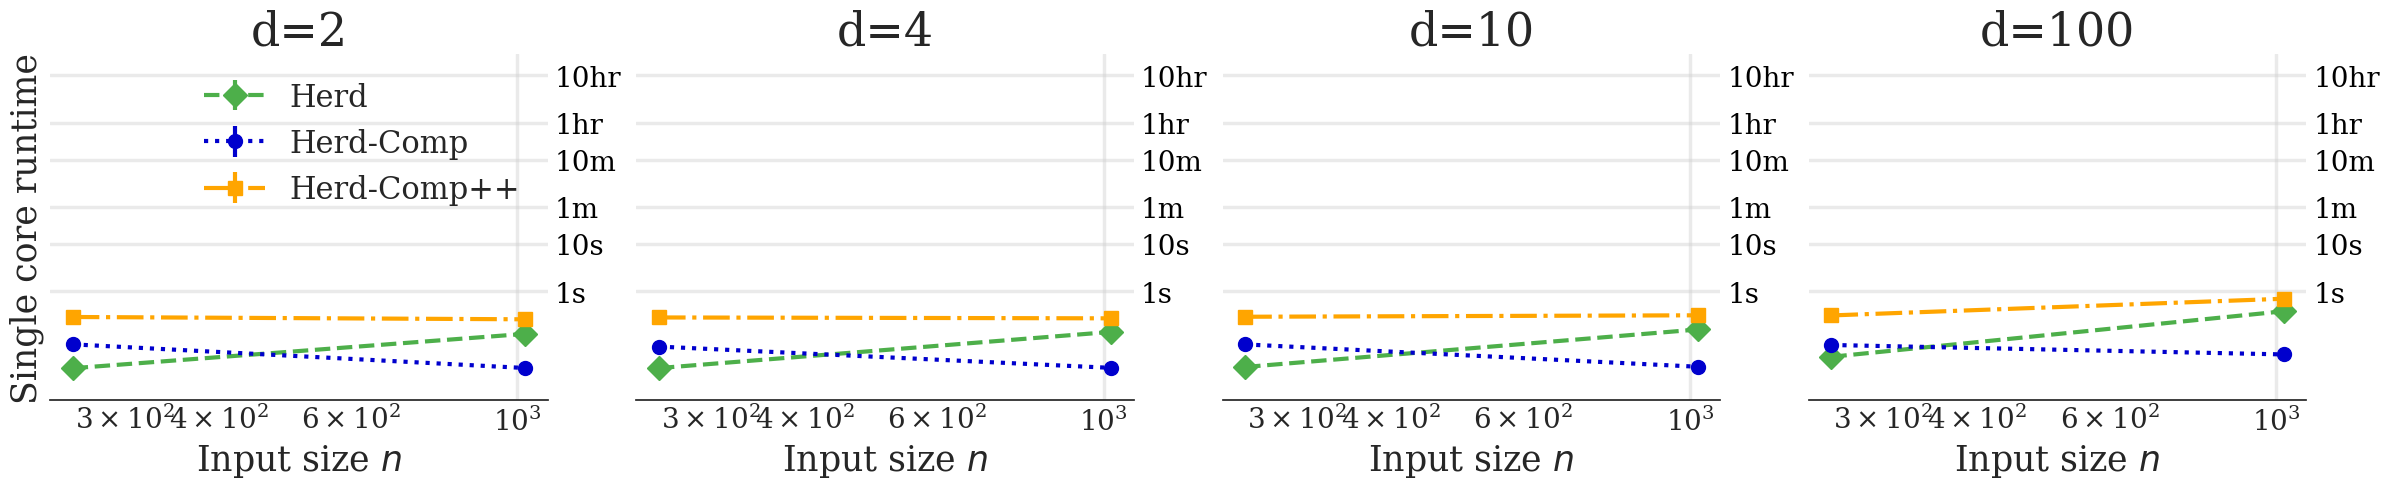

In [98]:
savefig = False
for ylog in [True]:
    axes = plt.subplots(1, len(d_time), figsize=[6*len(d_time), 5], sharex=True, sharey=False)
    for i, d, in enumerate(d_time):
        ax = axes[1][i]
        
        y =  herding_times[i, :, :].mean(1)
        yerr =  herding_times[i, :, :].std(1) / np.sqrt(args.repn)
        ax.errorbar(4**np.array(size_time[:]), y[:], marker=mss[0], 
                yerr=yerr[:], #np.array([-yerr, yerr]),
                linestyle=lss[0], markersize=ms_size[0]/2, color=colors[0], linewidth =3,
                 label='Herd')
        for a, g in enumerate(gs): #range(0, min(g_max, size)+1):
            y = cpp_herding_times[i, a, :, :].mean(1)
            yerr = cpp_herding_times[i, a, :, :].std(1) / np.sqrt(args.repn)
            if g == 0:
                lab = "Herd-Comp"
            else:
                lab = 'Herd-Comp++'
            ax.errorbar(4**np.array(size_time), y, yerr=np.array([-yerr, yerr]),
                    marker=mss[1+a], linestyle=lss[a+1], markersize=ms_size[1+a]/2,
                    color=colors[1+a], linewidth = 3,
    #                 linestyle='--', 
                    label=lab)
        ax.set_xscale('log', basex=10)
        if ylog:
            ax.set_yscale('log', basey=10)
            ax.set_ylim([5*1e-3, 1e5])
            ax.yaxis.tick_right()
            ax.set_yticks([1, 10, 60, 600, 3600, 36000])
            ax.set_yticklabels( ['1s', '10s', '1m', '10m', '1hr', '10hr'], fontsize=20, color='black')
#             ax.set_xticks([10**3, 10**4, 10**5, 10**6])
#             ax.set_xticklabels( ['1K','10K', '100K', '1M'], fontsize=20, color='gray')
        ax.set_xlabel(r'Input size $n$' , fontsize=xlab_size)

        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        # ax.spines['bottom'].set_visible(False)a
        
        ax.grid(True, alpha=0.4)
        ax.set_title("d=%d"%d, fontsize=1.1*title_size)
        if i == 0:
#             locs, labels = ax.get_yticks()  
#             ax.set_yticks([1, 60, 600, 3600, 36000, 86400])
            ax.set_ylabel('Single core runtime',fontsize=ylab_size)
            ax.legend(fontsize=22)
    plt.tight_layout()
    if savefig:
        if max(size_time) == 10:
            plt.savefig(fig_dir + "time_herd_4_10.pdf")
        else:
            plt.savefig(fig_dir + "time_herd.pdf")
    plt.show()

In [99]:
for i, d, in enumerate(d_time):
    print(d, herding_times[i, :, :].mean(1) / cpp_herding_times[i, 1, :, :].mean(1), herding_times[i, :, :].mean(1) , cpp_herding_times[i, 1, :, :].mean(1))

2 [0.08296056 0.49273808] [0.02375109 0.1260665 ] [0.28629379 0.25584892]
4 [0.08545877 0.51803179] [0.02391606 0.13886753] [0.27985499 0.26806759]
10 [0.08715544 0.50175119] [0.02523887 0.15590233] [0.2895845  0.31071641]
100 [0.13411005 0.54423377] [0.04139937 0.37837615] [0.30869697 0.69524563]
